In [1]:
import os
import re
import time
import kaggle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    VotingClassifier
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

pd.set_option('display.max_colwidth', None)

In [2]:
downloads = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'omw-1.4',
    'averaged_perceptron_tagger_eng'
]
for item in downloads:
    nltk.download(item)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       d

In [3]:
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('team-ai/spam-text-message-classification',unzip=True,path='./data')

In [4]:
df = pd.read_csv('./data/SPAM text message 20170820 - Data.csv')
df.sample(5)

,Category,Message
1318,spam,"Win the newest “Harry Potter and the Order of the Phoenix (Book 5) reply HARRY, answer 5 questions - chance to be the first among readers!"
5277,ham,"Best msg: It's hard to be with a person, when u know that one more step foward will make u fall in love.. &amp; One step back can ruin ur friendship.. good night:-) ..."
2089,spam,Well done ENGLAND! Get the official poly ringtone or colour flag on yer mobile! text TONE or FLAG to 84199 NOW! Opt-out txt ENG STOP. Box39822 W111WX £1.50
3962,ham,Your dad is back in ph?
1552,ham,In e msg jus now. U said thanks for gift.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

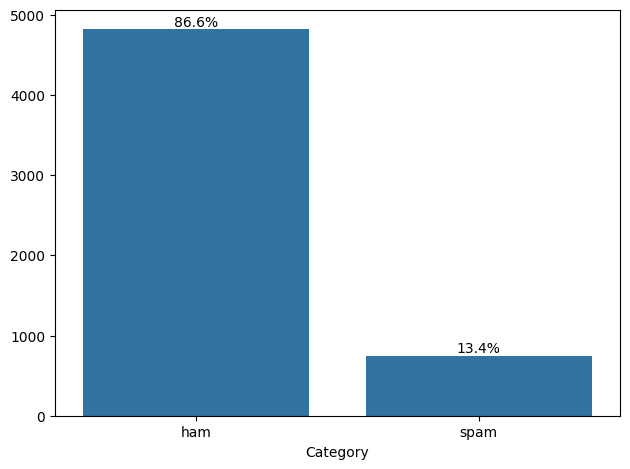

In [7]:
counts = df['Category'].value_counts()
ax = sns.barplot(x=counts.index, y=counts.values)

total = counts.sum()
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v/total:.1%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [8]:
# LabelEncoding the category
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [9]:
# Checking for Emoji as in this case (Sentiment analysis) it important
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "]+",
    flags=re.UNICODE
)

df["Message"].apply(lambda x: bool(emoji_pattern.search(str(x)))).value_counts()

Message
False    5572
Name: count, dtype: int64

# No Emoji is present

In [10]:
# Function to clean text and normalizing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)        # HTML
    text = re.sub(r'\d+', '', text)          # numbers
    text = re.sub(r'[^\w\s]', '', text)      # punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text) # emojis
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Retain numerical values since they are important indicators of spam
def clean_text_improved(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', ' num_token ', text) 
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
# Removing the punctuation mark and lowercasing the msg
df['text'] = df['Message'].apply(clean_text_improved)
df.drop(columns='Message',inplace=True)

In [13]:
#Tokenization
df['text'] = df['text'].apply(word_tokenize)

In [14]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(
    lambda x: [w for w in x if w.lower() not in stop_words]
)
df

,Category,text
0,0,"[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, num_token, wkly, comp, win, fa, cup, final, tkts, num_token, st, may, num_token, text, fa, num_token, receive, entry, questionstd, txt, ratetcs, apply, num_token, num_token]"
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, though]"
...,...,...
5567,1,"[num_token, nd, time, tried, num_token, contact, u, u, num_token, pound, prize, num_token, claim, easy, call, num_token, num_token, num_token, p, per, minute, btnationalrate]"
5568,0,"[ü, b, going, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestions]"
5570,0,"[guy, bitching, acted, like, id, interested, buying, something, else, next, week, gave, us, free]"


In [15]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(tokens):
    pos_tags = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

df['text'] = df['text'].apply(lemmatize_with_pos)
df

,Category,text
0,0,"[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]"
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, num_token, wkly, comp, win, fa, cup, final, tkts, num_token, st, may, num_token, text, fa, num_token, receive, entry, questionstd, txt, ratetcs, apply, num_token, num_token]"
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, go, usf, life, around, though]"
...,...,...
5567,1,"[num_token, nd, time, try, num_token, contact, u, u, num_token, pound, prize, num_token, claim, easy, call, num_token, num_token, num_token, p, per, minute, btnationalrate]"
5568,0,"[ü, b, go, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestion]"
5570,0,"[guy, bitch, act, like, id, interested, buying, something, else, next, week, give, u, free]"


In [16]:
df['text'] = df['text'].apply(lambda x : ' '.join(x))
df

,Category,text
0,0,go jurong point crazy available bugis n great world la e buffet cine get amore wat
1,0,ok lar joking wif u oni
2,1,free entry num_token wkly comp win fa cup final tkts num_token st may num_token text fa num_token receive entry questionstd txt ratetcs apply num_token num_token
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though
...,...,...
5567,1,num_token nd time try num_token contact u u num_token pound prize num_token claim easy call num_token num_token num_token p per minute btnationalrate
5568,0,ü b go esplanade fr home
5569,0,pity mood soany suggestion
5570,0,guy bitch act like id interested buying something else next week give u free


In [17]:
X = df['text']
y = df['Category']

# 2. Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")

Training Data Shape: (4457,)
Testing Data Shape: (1115,)


In [18]:
# 3. Vectorization (TF-IDF)
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

## Creating a simple function to directly run and evaluate models

In [19]:
def run_models(models, x_train=x_train_tfidf, x_test=x_test_tfidf, y_train=y_train, y_test=y_test, cmap="Blues"):
    summary_data = []

    for name, model in models.items():
        print("=" * 60)
        print(f"Model: {name}")
        print("=" * 60)

        start = time.time()
        model.fit(x_train, y_train)
        train_time = time.time() - start
        
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)

        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        summary_data.append({
            "Model": name,
            "Train F1": train_f1,
            "Test F1": test_f1,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
            "Test Accuracy": test_accuracy,
            "Gap (Overfitting)": train_f1 - test_f1, 
            "Training Time (s)": train_time
        })

        print(f"Training F1: {train_f1:.4f}")
        print(f"Testing F1:  {test_f1:.4f}")
        print(f"Testing Precision: {test_precision:.4f}")
        print(f"Testing Recall:    {test_recall:.4f}")

        print("-" * 30)
        print("Test Set Classification Report:")
        print(classification_report(y_test, y_test_pred))

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt="d", cmap=cmap, ax=axes[0])
        axes[0].set_title(f"Train Confusion Matrix - {name}")
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")

        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap=cmap, ax=axes[1])
        axes[1].set_title(f"Test Confusion Matrix - {name}")
        axes[1].set_xlabel("Predicted")
        axes[1].set_ylabel("Actual")

        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(summary_data)
    results_df = results_df.sort_values(by="Test F1", ascending=False)
    
    return results_df

In [20]:
# Initial Models Using class_weigh = 'Balanced' Where possible

Model: Naive Bayes
Training F1: 0.9421
Testing F1:  0.9071
Testing Precision: 1.0000
Testing Recall:    0.8299
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       968
           1       1.00      0.83      0.91       147

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



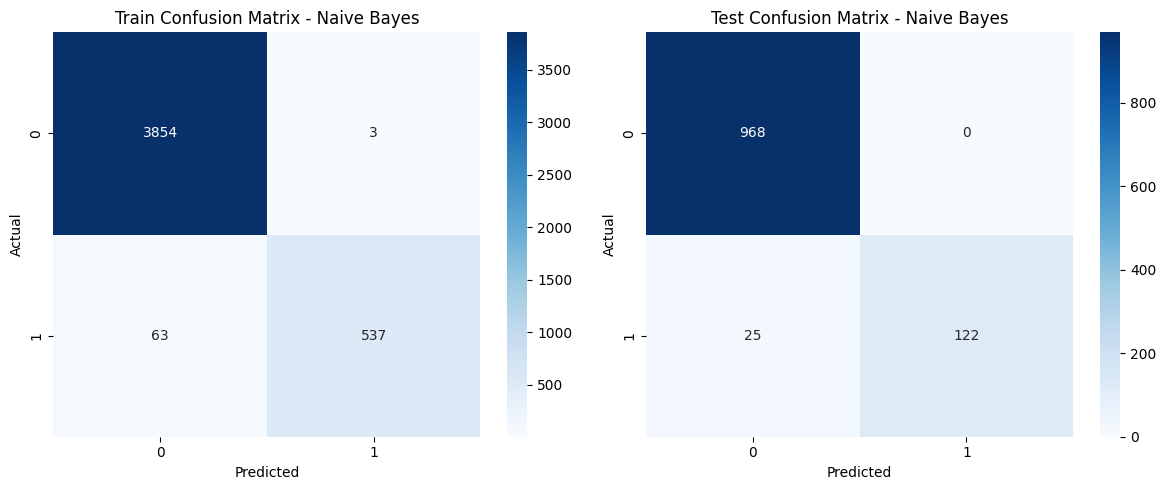

Model: Logistic Regression
Training F1: 0.9364
Testing F1:  0.9145
Testing Precision: 0.8854
Testing Recall:    0.9456
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       968
           1       0.89      0.95      0.91       147

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115



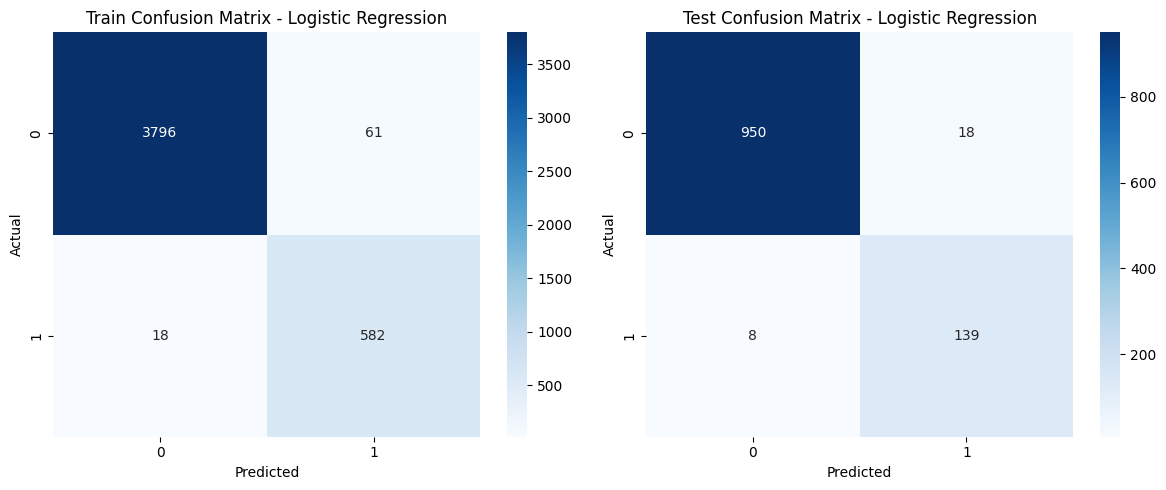

Model: Support Vector Machine
Training F1: 0.9812
Testing F1:  0.9320
Testing Precision: 0.9320
Testing Recall:    0.9320
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.93      0.93      0.93       147

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



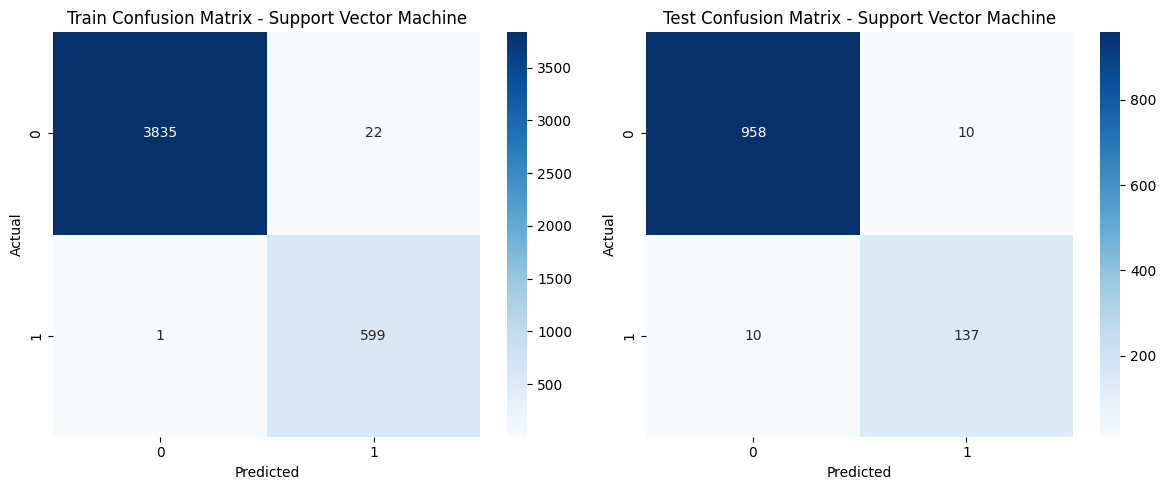

Model: Random Forest
Training F1: 0.9992
Testing F1:  0.9118
Testing Precision: 0.9920
Testing Recall:    0.8435
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       0.99      0.84      0.91       147

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



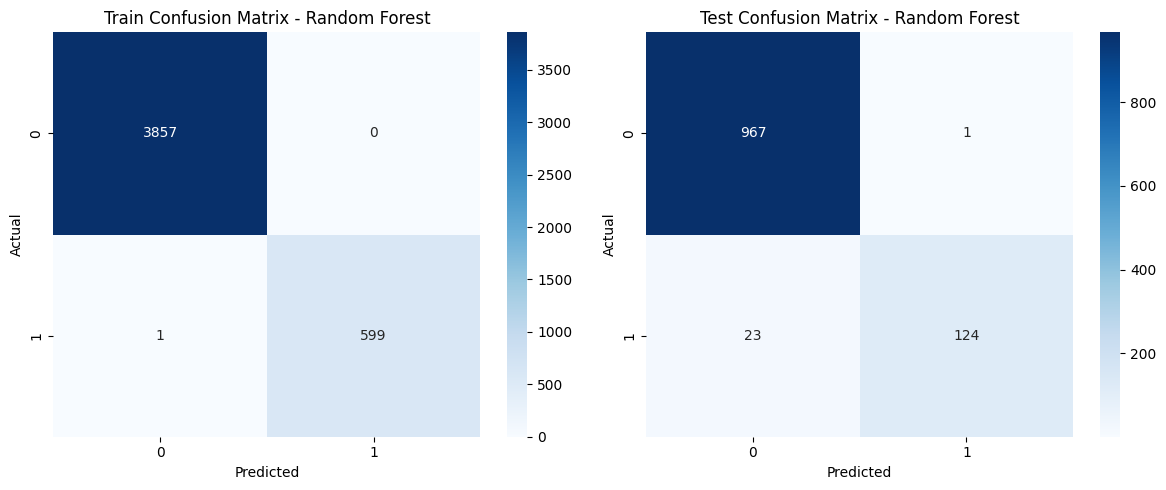

Model: Gradient Boosting
Training F1: 0.9599
Testing F1:  0.9058
Testing Precision: 0.9690
Testing Recall:    0.8503
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       0.97      0.85      0.91       147

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



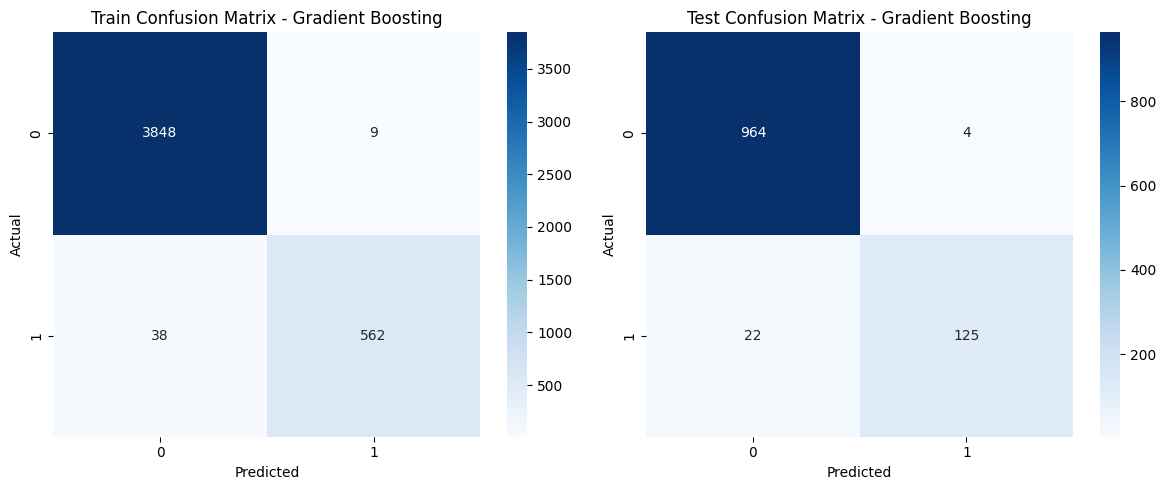

Model: AdaBoost
Training F1: 0.7940
Testing F1:  0.7919
Testing Precision: 0.7815
Testing Recall:    0.8027
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       968
           1       0.78      0.80      0.79       147

    accuracy                           0.94      1115
   macro avg       0.88      0.88      0.88      1115
weighted avg       0.95      0.94      0.94      1115



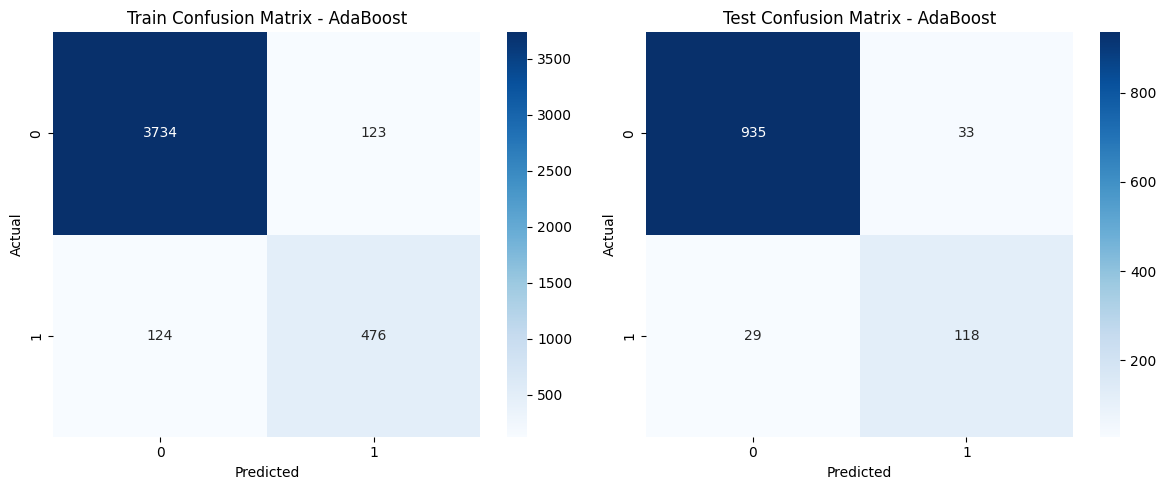

Model: K-Nearest Neighbors
Training F1: 0.7221
Testing F1:  0.5888
Testing Precision: 0.9403
Testing Recall:    0.4286
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       968
           1       0.94      0.43      0.59       147

    accuracy                           0.92      1115
   macro avg       0.93      0.71      0.77      1115
weighted avg       0.92      0.92      0.91      1115



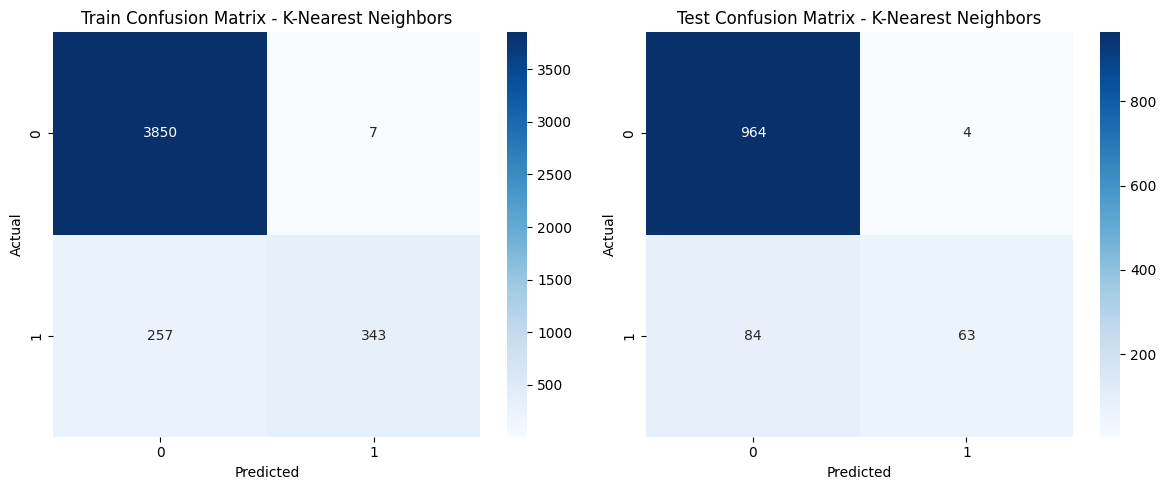

Model: Decision Tree
Training F1: 0.9967
Testing F1:  0.8424
Testing Precision: 0.7988
Testing Recall:    0.8912
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       968
           1       0.80      0.89      0.84       147

    accuracy                           0.96      1115
   macro avg       0.89      0.93      0.91      1115
weighted avg       0.96      0.96      0.96      1115



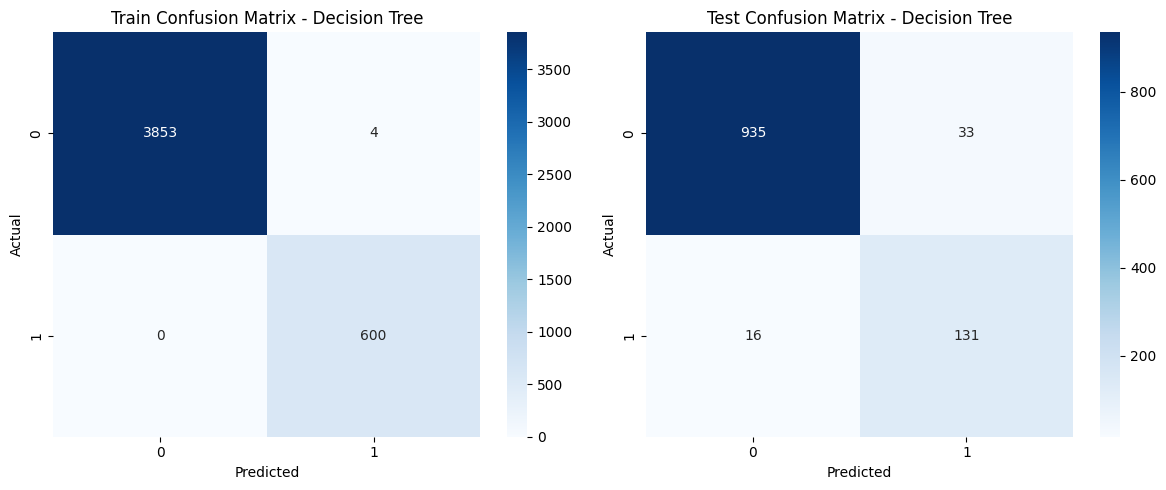

,Model,Train F1,Test F1,Test Precision,Test Recall,Test Accuracy,Gap (Overfitting),Training Time (s)
2,Support Vector Machine,0.981163,0.931973,0.931973,0.931973,0.982063,0.049190,0.265948
1,Logistic Regression,0.936444,0.914474,0.885350,0.945578,0.976682,0.021970,0.015692
3,Random Forest,0.999166,0.911765,0.992000,0.843537,0.978475,0.087401,0.793915
0,Naive Bayes,0.942105,0.907063,1.000000,0.829932,0.977578,0.035042,0.000000
4,Gradient Boosting,0.959863,0.905797,0.968992,0.850340,0.976682,0.054066,0.960037
7,Decision Tree,0.996678,0.842444,0.798780,0.891156,0.956054,0.154234,0.092435
5,AdaBoost,0.793995,0.791946,0.781457,0.802721,0.944395,0.002049,0.287848
6,K-Nearest Neighbors,0.722105,0.588785,0.940299,0.428571,0.921076,0.133320,0.000000


In [21]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=7),
    "Support Vector Machine": SVC(kernel="linear", class_weight="balanced", random_state=7),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=7),
    "AdaBoost": AdaBoostClassifier(random_state=7),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=7
    )
}

run_models(models)

# Since in this case Precision is more important than recall we go with SVM, rf or Naive Bayes  (marking a job offer as spam is a disaster)

Model: Voting Classifier (NB + RF + SVM)
Training F1: 0.9925
Testing F1:  0.9209
Testing Precision: 0.9771
Testing Recall:    0.8707
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       0.98      0.87      0.92       147

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



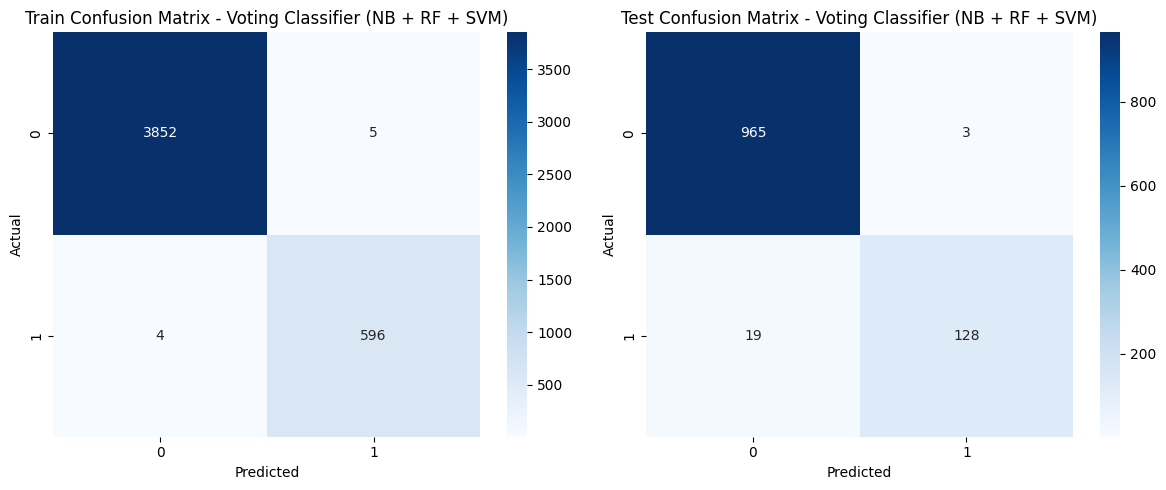

,Model,Train F1,Test F1,Test Precision,Test Recall,Test Accuracy,Gap (Overfitting),Training Time (s)
0,Voting Classifier (NB + RF + SVM),0.992506,0.920863,0.977099,0.870748,0.980269,0.071643,2.190466


In [22]:
voting_clf = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('rf', RandomForestClassifier(class_weight='balanced')),
        ("SVM", SVC(kernel="linear", class_weight="balanced", random_state=7,probability=True))
        
    ],
    voting='soft'
)

run_models({"Voting Classifier (NB + RF + SVM)": voting_clf})

# Lets Tune All the Three Models

In [23]:
# ==========================================
# 1. Tune Multinomial Naive Bayes
# ==========================================
print("Tuning Multinomial Naive Bayes")
nb_params = {
    'alpha': [0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0]  # Smoothing parameter
}
grid_nb = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='f1', n_jobs=-1)
grid_nb.fit(x_train_tfidf, y_train)

best_nb = grid_nb.best_estimator_
print(f"Best NB Params: {grid_nb.best_params_}")

Tuning Multinomial Naive Bayes
Best NB Params: {'alpha': 0.1}


In [24]:
# ==========================================
# 2. Tune Random Forest
# ==========================================
print("Tuning Random Forest")
rf_params = {
    'n_estimators': [100, 300],          # Number of trees
    'max_depth': [None, 20, 50],         # Maximum depth of tree
    'min_samples_split': [2, 5, 10],     # Minimum samples required to split a node
    'class_weight': ['balanced']         # Essential for imbalanced spam data
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=7), rf_params, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(x_train_tfidf, y_train)

best_rf = grid_rf.best_estimator_
print(f"Best RF Params: {grid_rf.best_params_}")

Tuning Random Forest
Best RF Params: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 100}


In [25]:
# ==========================================
# 3. Tune SVM
# ==========================================
print("Tuning SVM (Linear Kernel)...")
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': ['balanced']
}

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=7), 
    svm_params, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)
grid_svm.fit(x_train_tfidf, y_train)

print(f"Best SVM Params: {grid_svm.best_params_}")

Tuning SVM (Linear Kernel)...
Best SVM Params: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}


Model: Tuned Naive Bayes
Training F1: 0.9614
Testing F1:  0.9386
Testing Precision: 1.0000
Testing Recall:    0.8844
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       1.00      0.88      0.94       147

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.99      0.98      0.98      1115



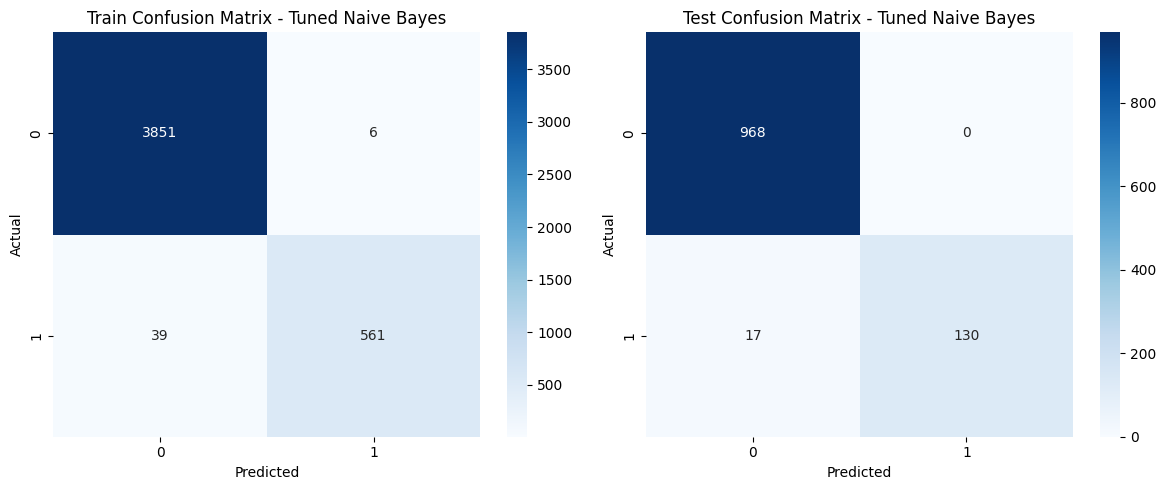

Model: Tuned Random Forest
Training F1: 0.9831
Testing F1:  0.9143
Testing Precision: 0.9624
Testing Recall:    0.8707
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       968
           1       0.96      0.87      0.91       147

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



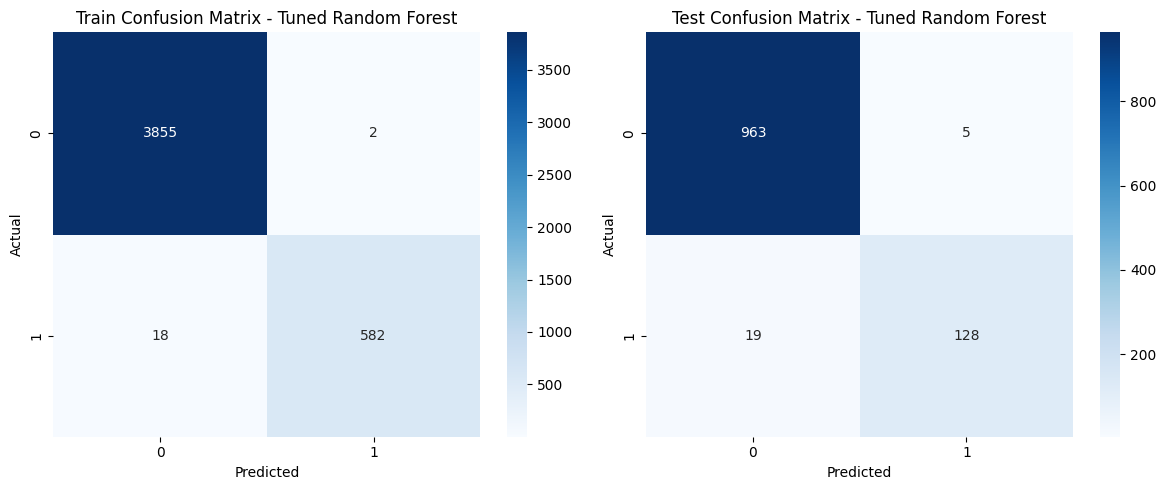

Model: Tuned SVM
Training F1: 0.9959
Testing F1:  0.9324
Testing Precision: 0.9776
Testing Recall:    0.8912
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       968
           1       0.98      0.89      0.93       147

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



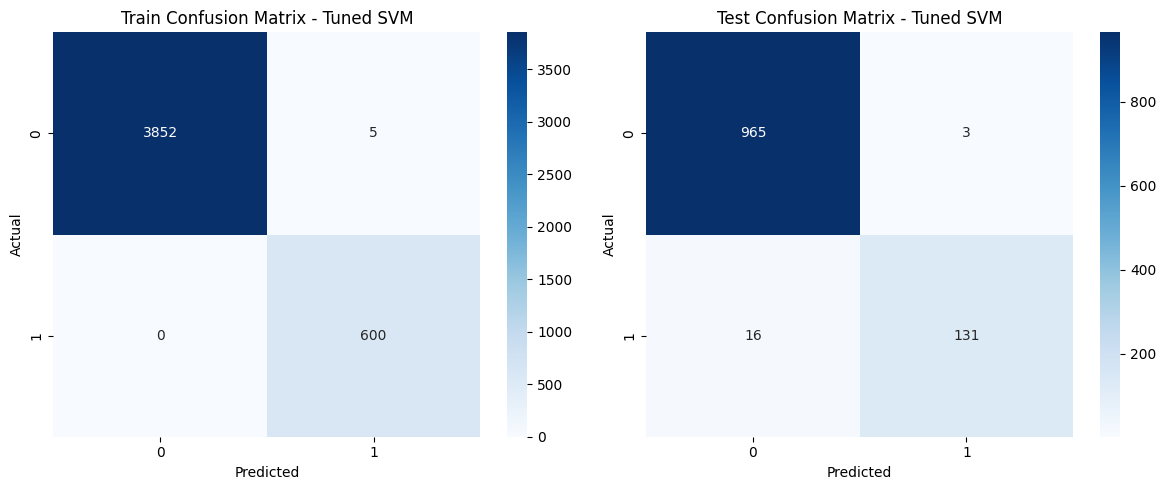

,Model,Train F1,Test F1,Test Precision,Test Recall,Test Accuracy,Gap (Overfitting),Training Time (s)
0,Tuned Naive Bayes,0.961440,0.938628,1.000000,0.884354,0.984753,0.022811,0.004541
2,Tuned SVM,0.995851,0.932384,0.977612,0.891156,0.982960,0.063466,1.155131
1,Tuned Random Forest,0.983108,0.914286,0.962406,0.870748,0.978475,0.068822,0.498574


In [26]:
tuned_models = {
    "Tuned Naive Bayes": grid_nb.best_estimator_,
    "Tuned Random Forest": grid_rf.best_estimator_,
    "Tuned SVM": grid_svm.best_estimator_
}
run_models(tuned_models)

# Tuned Voting Classifier

Model: Final Voting Ensemble
Training F1: 0.9891
Testing F1:  0.9433
Testing Precision: 0.9852
Testing Recall:    0.9048
------------------------------
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       968
           1       0.99      0.90      0.94       147

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



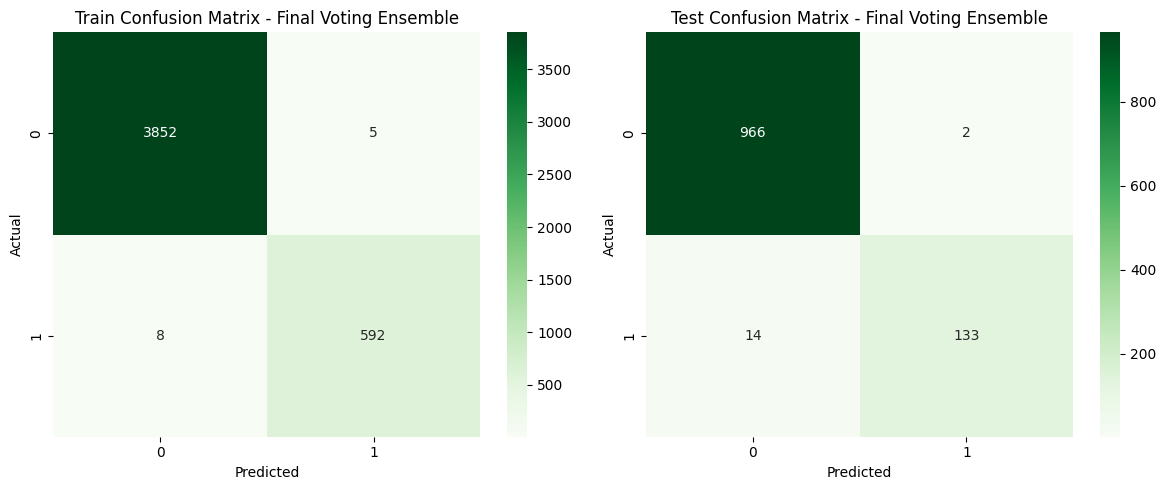

,Model,Train F1,Test F1,Test Precision,Test Recall,Test Accuracy,Gap (Overfitting),Training Time (s)
0,Final Voting Ensemble,0.98914,0.943262,0.985185,0.904762,0.98565,0.045877,1.659477


In [27]:
tuned_voting_clf = VotingClassifier(
    estimators=[
        ('nb', grid_nb.best_estimator_), 
        ('rf', grid_rf.best_estimator_),
        ('svm', grid_svm.best_estimator_)
    ],
    voting='soft'
)

run_models({"Final Voting Ensemble": tuned_voting_clf},cmap='Greens')